# DataLoader

`torch.utils.data.DataLoader` 是一个用来简化数据读取的类，我们将学习如何使用 `DataLoader` 来读取数据集。

To run this tutorial, please make sure the following packages are installed:

- scikit-image: For image io and transforms
- pandas: For easier csv parsing

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

数据集包含一个带注释的csv文件，如下所示：

>image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
>
>0805personali01.jpg,27,83,27,98, ... 84,134
>
>1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312

让我们快速阅读CSV并获取（N，2）数组中的注释，其中N是特征点的数量。

In [2]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]  # 图片
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()  # landmarks矩阵
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


让我们编写一个简单的辅助函数来显示图像及其特征点，并使用它来显示样例。

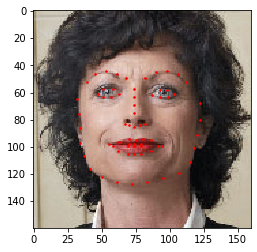

In [3]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)  # 展示图片
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')  # 红点展示
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),landmarks)

plt.show()

## Dataset class

torch.utils.data.Dataset是表示数据集的抽象类。您的自定义数据集应继承Dataset，并覆盖下列方法：

- **`__len__`**，使得len(dataset)返回数据集的大小。
- **`__getitem__`**支持索引，使得dataset[i]可以用来获取第i个样本

让我们为面部轮廓数据集创建一个数据集类。我们将在`__init__`中读取csv文件，在`__getitem__`中读取图像。由于所有图像不会立即存储在内存中，而是根据需要读取，因此可以提高内存效率。

我们的数据集中的样品是一个字典`{'image': image, 'landmarks': landmarks}`。我们的数据集将采取一个可选的参数`transform`，以便可以对样本进行任何必需的处理。我们将在下一节看`到transform`的用处。

In [4]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): csv文件的路径.
            root_dir (string): 所有图像的目录.
            transform (callable, optional): 图像增强.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        """数据集大小"""
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        """获取第 i 个样本"""
        if torch.is_tensor(idx):
            idx = idx.tolist()  # 将矩阵转换为列表

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])  # 图片名称
        image = io.imread(img_name)  # 图片
        landmarks = self.landmarks_frame.iloc[idx, 1:]  # landmark，dataframe
        landmarks = np.array([landmarks])  # 变成数组
        landmarks = landmarks.astype('float').reshape(-1, 2)  # 浮点数
        sample = {'image': image, 'landmarks': landmarks}  # 存入字典

        if self.transform:
            sample = self.transform(sample)

        return sample

让我们实例化该类并遍历数据样本。我们将打印前4个样本的大小并显示其特征点。

69
0 (324, 215, 3) (68, 2)


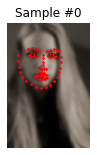

1 (500, 333, 3) (68, 2)


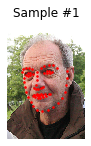

2 (250, 258, 3) (68, 2)


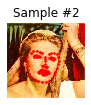

3 (434, 290, 3) (68, 2)


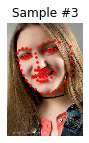

In [9]:
# 读取数据集
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

# 画图
fig = plt.figure()

print(len(face_dataset))  # 69张图片

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break  # 暂停循环

## 转换（Transforms）

从上面可以看到的一个问题是样本的大小不同。大多数神经网络期望图像的大小固定。因此，我们将需要编写一些前置代码。让我们创建三个转换：：

- `Rescale`：图像缩放
- `RandomCrop`：从图像中随机裁剪。这是数据扩充。
- `ToTensor`：将numpy格式的图片转换为torch格式的图片（我们需要换轴）。

我们将它们编写为可调用的类，而不是简单的函数，这样就不必每次调用转换时都传递其参数。为此，我们只需要实现`__call__`方法，如果需要的话，可以实现`__init__`方法。然后我们可以使用这样的转换：

In [11]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## 组合转换（Compose transforms）

现在，我们将转换应用于样本。

假设我们要将图像的较短边重新缩放为256，然后从中随机裁剪一个尺寸为224的正方形。即我们要组成`Rescale`和`RandomCrop`变换。 `torchvision.transforms.Compose` 是一个简单的可调用类，它使我们可以执行此操作。

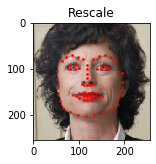

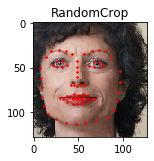

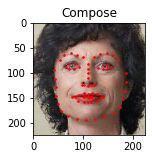

In [12]:
scale = Rescale(256)  # 缩放
crop = RandomCrop(128)  # 剪裁
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

## 遍历数据集

让我们将所有这些放在一起以创建具有组合转换的数据集。总而言之，每次采样此数据集时：

- 从文件中即时读取图像
- 将变换应用于读取的图像
- 由于其中一种转换是随机的，因此在采样时会增加数据

我们可以像之前一样通过一个`for i in range`循环遍历创建的数据集。

In [17]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]  # sample 是一个字典的形式，里面分别是image和landmark

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


但是，通过使用简单的`for`循环迭代数据，我们失去了很多功能。特别是，我们错过了：

- 批量处理数据
- 整理数据
- 使用`multiprocessing`并行加载数据。

`torch.utils.data.DataLoader`是提供所有这些功能的迭代器。下面使用的参数应该清楚。一个重要参数是`collate_fn`。您可以使用指定要精确批处理样品的数量`collate_fn`。但是，默认排序规则在大多数情况下都可以正常工作。

In [27]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)
dataloader

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


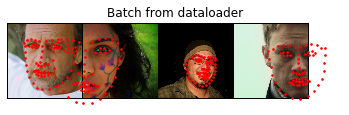

In [28]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)  # 一个batch多大
    im_size = images_batch.size(2)  # 图片的大小
    grid_border_size = 2  # 边缘长度

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        # 画点
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')
        # 标题
        plt.title('Batch from dataloader')

# 每次不一样，因为shuffle了
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## 后记：torchvision

在本教程中，我们已经看到了如何构造和使用数据集，转换数据和的数据加载。`torchvision`软件包提供了一些常见的数据集和转换。您甚至不必编写自定义类。`torchvision`中可用的更通用的数据集之一是`ImageFolder`。

假定图像的组织方式如下：

```
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
.
.
.
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png
```

其中“ants”，“bees”等是类标签。同样也可以使用`PIL.Image`中的操作像 `RandomHorizontalFlip`和`Scale`来进行通用转换。您可以使用以下代码创建一个数据加载器：

```python
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)
```